In [60]:
import tensorflow.keras as keras
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime
import boto3
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [61]:
dataset = pd.read_csv("ev_data_processed.csv")

# Indexing the data with respect to time_stamp
dataset['time_stamp'] = pd.to_datetime(dataset['time_stamp'], infer_datetime_format= True)
Original_indexed_dataset = dataset.set_index(['time_stamp'])

# Re-samples the data by the hour and sums all the data in that hour
Hourly_data = Original_indexed_dataset.resample('H').sum() 

In [62]:
from datetime import datetime
Hourly_data.head(20)

,power
time_stamp,
2020-01-05 02:00:00,7200
2020-01-05 03:00:00,93600
2020-01-05 04:00:00,100800
2020-01-05 05:00:00,187200
2020-01-05 06:00:00,86400
2020-01-05 07:00:00,187200
2020-01-05 08:00:00,237600
2020-01-05 09:00:00,165600
2020-01-05 10:00:00,172800


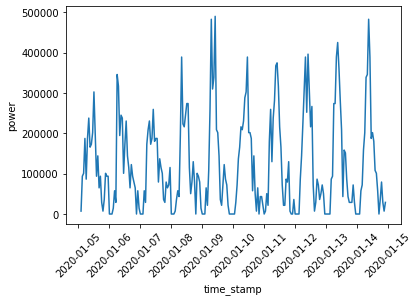

In [63]:
plt.xlabel('time_stamp')
plt.ylabel('power')
plt.plot(Hourly_data)
plt.show
plt.tick_params(axis ='x', rotation = 45)

In [64]:
# Split the dataset into train(90%) and test (10%)
num_data = len(Hourly_data)
num_train = int(0.90*num_data)
num_test = num_data - num_train
training_data = Hourly_data[0:num_train]
testing_data = Hourly_data[num_test:]

# Normalize the dataset
scalar = MinMaxScaler()
scalar.fit(training_data)
scalar.fit(testing_data)
train_data = np.asarray(scalar.transform(training_data))
test_data = np.asarray(scalar.transform(testing_data))

In [65]:
n_input = 24
n_features = 1
generator = keras.preprocessing.sequence.TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=5)

In [66]:
# LSTM model
model = Sequential()
model.add(LSTM(192, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=200)

Epoch 1/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0697
Epoch 2/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0506
Epoch 3/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0471
Epoch 4/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0383
Epoch 5/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0289
Epoch 6/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0258
Epoch 7/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0175
Epoch 8/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0196
Epoch 9/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0176
Epoch 10/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0154
Epoch 11/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0167
Epoch 12/200
38/38 [==============================] - 1s 27ms/step - loss: 0.0159
Epoch 13/200
38/38 [=====

In [68]:
predict_data = []
batch = test_data[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
  predict_data.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predict_data[i]]], axis=1 )
hourly_data_prediction = pd.DataFrame(scalar.inverse_transform(predict_data), index = Hourly_data[-n_input:].index, columns=['prediction'])
hourly_data_test = pd.concat([Hourly_data, hourly_data_prediction], axis=1)

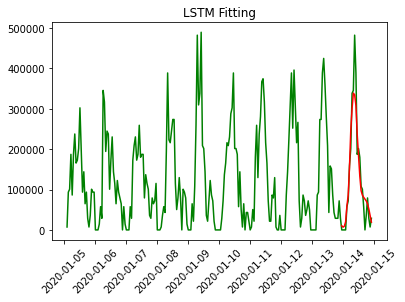

In [73]:
plt.plot(hourly_data_test.index, hourly_data_test['power'],color = 'green',label = 'original')
plt.plot(hourly_data_test.index,hourly_data_test['prediction'],color='red', label ='prediction')
plt.title('LSTM Fitting')
plt.tick_params(axis ='x', rotation = 45)
plt.show()

In [75]:
# Forecast future power consumption

future_data = Hourly_data
scalar.fit(future_data)
future_prediction = scalar.transform(future_data)
generator = keras.preprocessing.sequence.TimeseriesGenerator(future_prediction, future_prediction, length=n_input, batch_size=5)
model.fit_generator(generator, epochs=150)

Epoch 1/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0081
Epoch 2/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0086
Epoch 3/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0077
Epoch 4/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0067
Epoch 5/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0064
Epoch 6/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0061
Epoch 7/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0067
Epoch 8/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0069
Epoch 9/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0064
Epoch 10/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0067
Epoch 11/150
43/43 [==============================] - 1s 27ms/step - loss: 0.0075
Epoch 12/150
43/43 [==============================] - 1s 28ms/step - loss: 0.0081
Epoch 13/150
43/43 [=====

In [80]:
predict_future_data = []
batch = future_prediction[-n_input:].reshape((1,n_input,n_features))

for i in range(n_input):
  predict_future_data.append(model.predict(batch)[0])
  batch = np.append(batch[:,1:,:], [[predict_future_data[i]]], axis = 1)
add_dates = [Hourly_data.index[-1] + DateOffset(hours=x) for x in range(0,25)]
future_dates = pd.DataFrame(index=add_dates[1:], columns=Hourly_data.columns)
charger_data_prediction = pd.DataFrame(scalar.inverse_transform(predict_future_data), index = future_dates[-n_input:].index, columns=['prediction'])
charger_data_projection = pd.concat([Hourly_data, charger_data_prediction], axis=1)

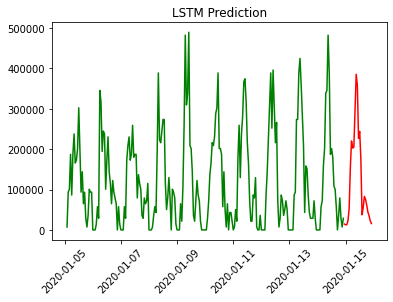

In [81]:
plt.plot(charger_data_projection.index, charger_data_projection['power'],color = 'green',label = 'original')
plt.plot(charger_data_projection.index,charger_data_projection['prediction'],color='red', label ='prediction')
plt.title('LSTM Prediction')
plt.tick_params(axis ='x', rotation = 45)
plt.show()